# Swamp Angel Observations

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

# Original Swamp Angel observations
dirDataRaw = dirPre + 'GroundObs/SenatorBeck/Raw'

## Read and format the Senator Beck data

In [3]:
# --------------------------------------------------------------------------------------------
# data parser functions
def parser(x):
    return(pd.datetime.strptime(x, '%Y %j %H'))

def hourConverter(x):
    x = float(x)-100.
    if x >= 1000.:
        x = str(int(x/100))
    elif x < 1000. and x >= 0.:
        x = '0'+str(int(x/100))
    return x

In [4]:
# --------------------------------------------------------------------------------------------
# Read the Senator Beck data
os.chdir(dirDataRaw)
fields_to_keep = ['Hour',
                  'Year',
                  'DOY',
                  'UpWind_Uavg_MS',
                  'PyDwn_Unfilt_W',
                  'PyUp_Unfilt_W',
                  'Pyrgeom_W',
                  'Sno_IR_C',
                  'Soil_Surf_C',
                  'UpAir_Min_C',
                  'UpAir_Max_C',
                  'Up_RH',
                  'Sno_Height_M',
                  'Day_H2O_mm'
                 ]

SWA = pd.read_csv('SASP_1hr.withHeader.txt',
                  converters={'Hour': hourConverter},
                  parse_dates={'time': ['Year', 'DOY', 'Hour']},
                  date_parser=parser,
                  index_col='time',
                  usecols=fields_to_keep,
                  header=0)

SWA = xr.Dataset.from_dataframe(SWA)

In [5]:
# --------------------------------------------------------------------------------------------
# Refine the Dataset
SWA.rename({'Sno_IR_C': 'Tsrf1',
            'Soil_Surf_C': 'Tsrf2',
            'PyDwn_Unfilt_W': 'SWup',
            'PyUp_Unfilt_W': 'SWdwn',
            'Pyrgeom_W': 'LWdwn',
            'UpWind_Uavg_MS': 'WIND',
            'Day_H2O_mm': 'precip',
            'Sno_Height_M': 'snowDepth',
            'Up_RH': 'RH'}, inplace=True)
SWA['Tair'] = (SWA.UpAir_Max_C + SWA.UpAir_Min_C) / 2
SWA = SWA.drop(['UpAir_Min_C', 'UpAir_Max_C'])


### Handle surface temperature

In [6]:
# Combine surface temperature time series into a single variable
# CSAS dataset splits up skin temperature into two separate fields: 'Snow_IR_C' and 'Soil_Surf_C'.
# These two different fields may be defined by snow depth. Using my own criteria below.
SWA['Tsrf'] = SWA.Tsrf1.combine_first(SWA.Tsrf2)
SWA = SWA.drop(['Tsrf2', 'Tsrf1'])
SWA['LWup'] = .98 * 5.67 * 10 ** (-8) * ( (SWA.Tsrf + 273.15) ** 4)

# Take daily average, reindex to half-hourly time series, use in snow presence criteria
TsrfDaily = SWA.Tsrf.resample(how='mean', freq='d', dim='time', label='left')
TsrfDaily = TsrfDaily.reindex_like(SWA, method='ffill')

# bare ground when no snowdepth recorded or the daily surface temperature is above freezing
groundSurfTemp = SWA.Tsrf[(SWA.snowDepth < 0.01) | (TsrfDaily > 0.5)]

# snow covered ground when snow is observed and the surface temperature is below freezing
snowSurfTemp = SWA.Tsrf[(SWA.snowDepth > 0.01) & (TsrfDaily < 0.5)]

# Assign to support xarray.Dataset
SWA['groundTs'] = groundSurfTemp
SWA['snowTs'] = snowSurfTemp

# Create snow presence variable
snowPres = ((SWA.snowDepth > 0.01) & (TsrfDaily < 0.5))
SWA['SP'] = snowPres.astype(int)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive


In [7]:
# -------------------------------------------------------------------------
# Write netcdf
os.chdir(dirData)
SWA.to_netcdf('SWA.ModTsfc.nc')
print(SWA)

<xarray.Dataset>
Dimensions:    (time: 84299)
Coordinates:
  * time       (time) datetime64[ns] 2003-11-08T13:00:00 2003-11-08T14:00:00 ...
Data variables:
    WIND       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    SWup       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    SWdwn      (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    LWdwn      (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    snowDepth  (time) float64 0.27 0.27 0.27 0.28 0.29 0.29 0.28 0.28 0.29 ...
    precip     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    RH         (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Tair       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Tsrf       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    LWup       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    groundTs   (time) float64 nan nan nan nan nan nan nan nan n

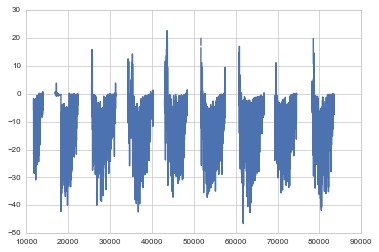

In [8]:
plt.plot(SWA.snowTs)